# BCM og

> Summary: implementation trying to stay as close to original description of BCM as possible, runaway activity problem

In [106]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import numpy as np
from utils import *


In [180]:
class BCM_Model(nn.Module):
    def __init__(self, n_in, n_units):
        super().__init__()
        # learnable params
      #  self.weights = torch.normal(mean=0, std=(2 / n_in)**(1/2),size=(n_units, n_in), dtype=torch.float64) # http://arxiv.org/abs/1502.01852
        self.weights = torch.normal( mean=0, std=1, size=(n_units, n_in),dtype=torch.float64)
        self.threshold = torch.zeros(n_units)

        # tracking
        self.selectivity = []
        self.activations = []
        self.threshold_trace = []
    
    def update(self, x, eps=1, dt=0.01):

        # update threshold
        y = torch.mm(self.weights, x) 
        self.threshold =  torch.mean(y**2, dim=1)
        t  = self.threshold.reshape(-1, 1)
        
        # calc weight update
        phi = y * (y - t) 
        delta_w =  torch.mm(phi, x.T)   - eps * self.weights
        delta_w /= batch_size # norm update with batchsize

        # update weights
        self.weights += delta_w * dt

      #  self.weights =  self.weights/torch.linalg.norm(self.weights)
        
        # tracking
        self.selectivity.append(selectivity_metric(y))
        self.threshold_trace.append(self.threshold)
        self.activations.append(torch.mean(y, dim=1)) # append mean over batch

torch.Size([10, 100])
tensor([ 1.2448e+31,  4.5501e+27,  6.9120e+33,  3.2938e+31, -9.6554e+32,
         3.5674e+35,  3.2847e+27,  3.3618e+38,  1.5829e+31,  1.1239e+34],
       dtype=torch.float64)


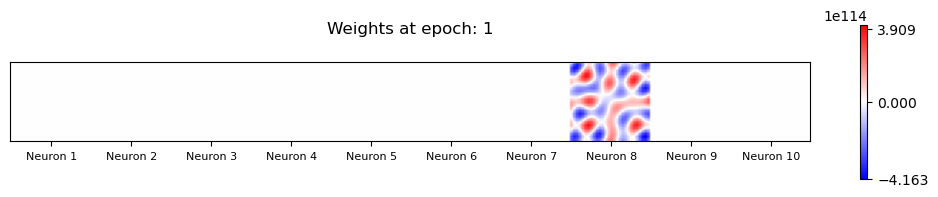

In [346]:
# load data
data_np = np.loadtxt("gratings.csv", delimiter=",")
data = torch.from_numpy(data_np)
n_samples, n_in = data.shape



# hps#
n_epochs = 1
n_units = 10
batch_size = 100

model = BCM_Model(n_in, n_units)
#model = BCM_Model_Squadrani(n_in, n_units)

# learning loop
for epoch in range(n_epochs):

    data = data[torch.randperm(n_samples)]  # Shuffle the input data

    # Iterate over all minibatches
    for i in range(n_samples // batch_size):
        minibatch = data[i * batch_size:(i + 1) * batch_size].T # transform to shape (n_in, batch_size)
        model.update(minibatch)
        draw_weights(model.weights, epoch)



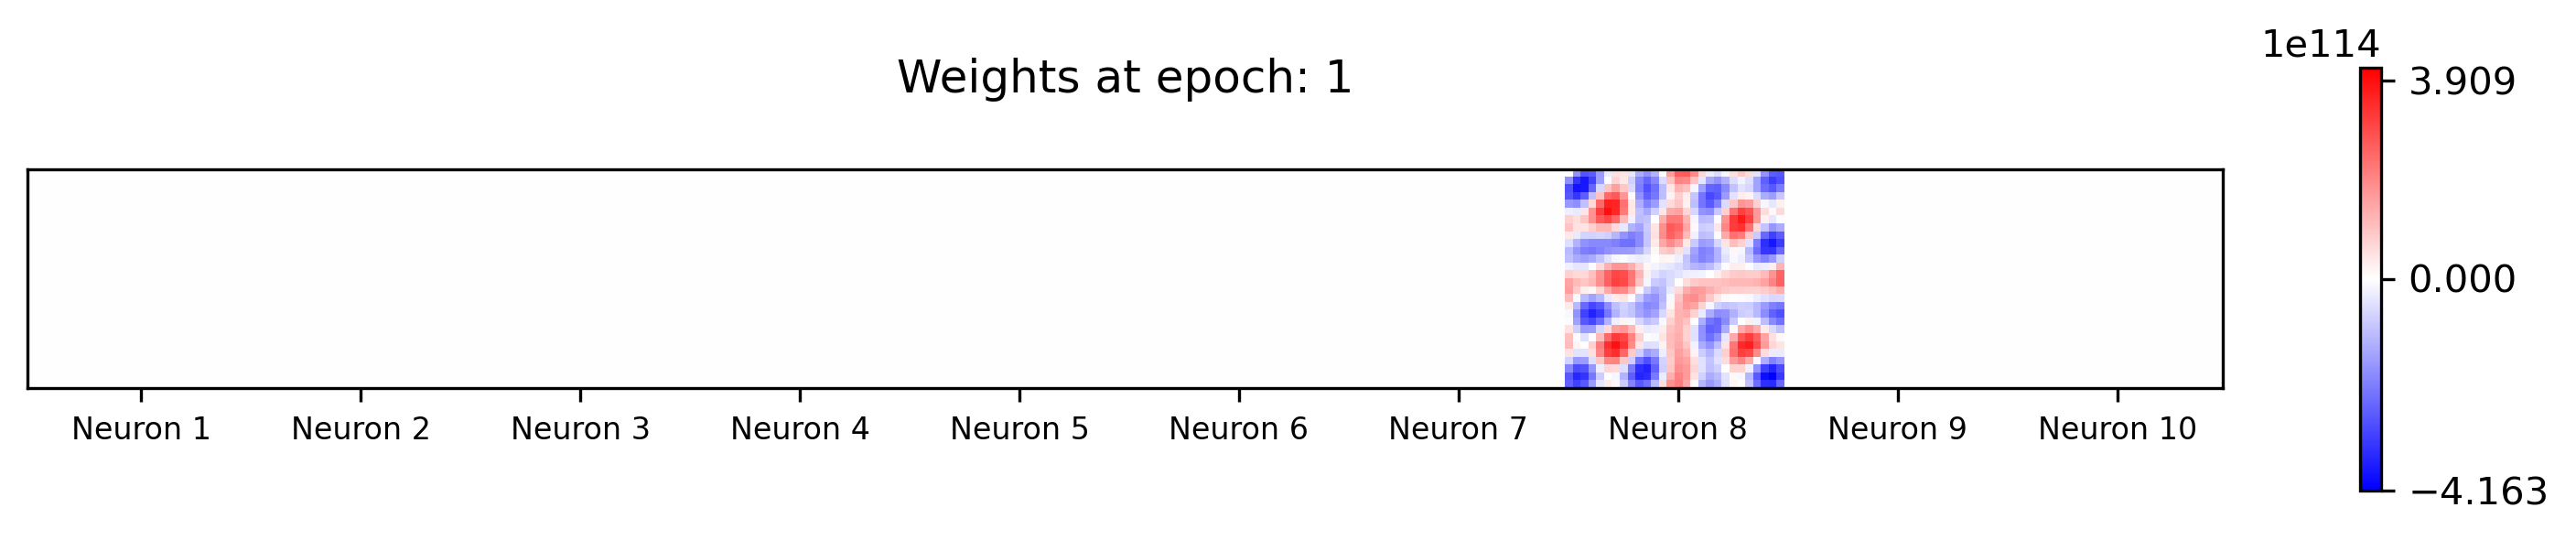

In [380]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
draw_weights(model.weights, epoch)

In [381]:
model.weights

tensor([[  9.5502e-01,   1.7785e+95,   3.1069e+95,  ...,   1.2176e+96,
           1.6970e+96,   1.5706e+96],
        [  2.1640e-02,  -1.2965e+83,  -2.0386e+83,  ...,  -2.0111e+83,
          -2.6973e+83,  -2.1308e+83],
        [ -1.4487e-01, -1.1488e+100, -1.8851e+100,  ..., -1.8676e+100,
         -1.7363e+100, -1.1096e+100],
        ...,
        [  1.8140e+00, -1.7747e+114, -2.7793e+114,  ..., -3.4014e+114,
         -3.4801e+114, -2.4376e+114],
        [  6.2098e-01,  -6.0298e+91,  -9.2313e+91,  ...,  -6.5242e+91,
          -7.9127e+91,  -5.3748e+91],
        [ -9.9701e-01, -1.6867e+101, -2.9305e+101,  ..., -3.9935e+101,
         -3.8353e+101, -3.0422e+101]], dtype=torch.float64)

### Visual Analysis

#### Selectivity

In [382]:
img = np.array(model.selectivity)
img =img.T

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

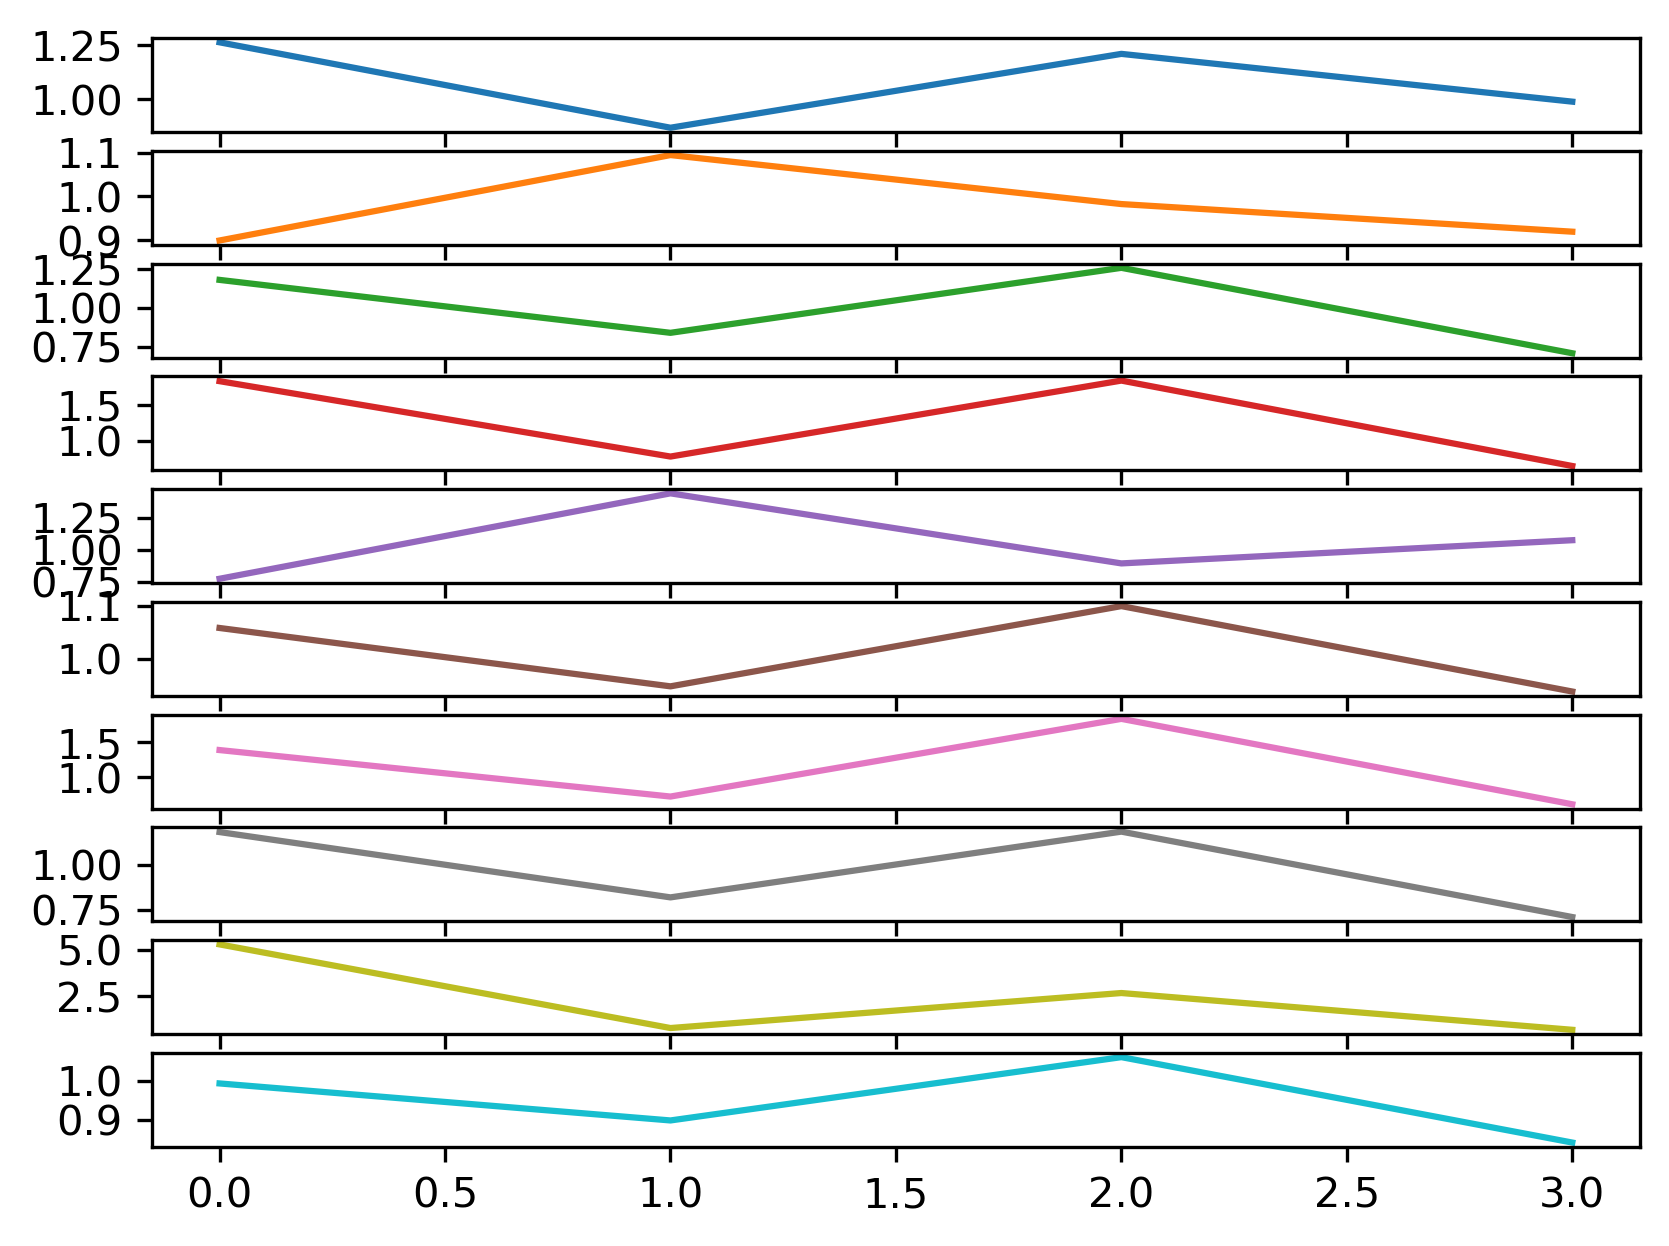

In [383]:
import pandas as pd
df = pd.DataFrame({f'neuron_{i}': img[i,:] for i in range(n_units)})
df.plot(subplots=True, legend=False)

#### Threshold

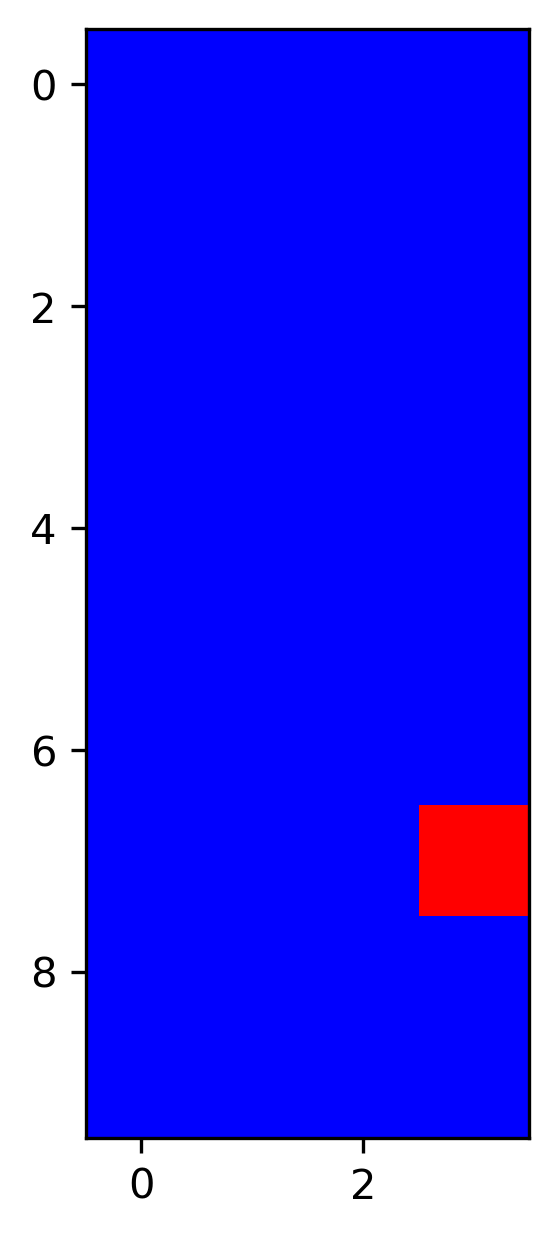

In [384]:
t = np.array(model.threshold_trace)
t = t.T
plt.imshow(t,cmap='bwr')

In [385]:
t.shape

(10, 4)

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

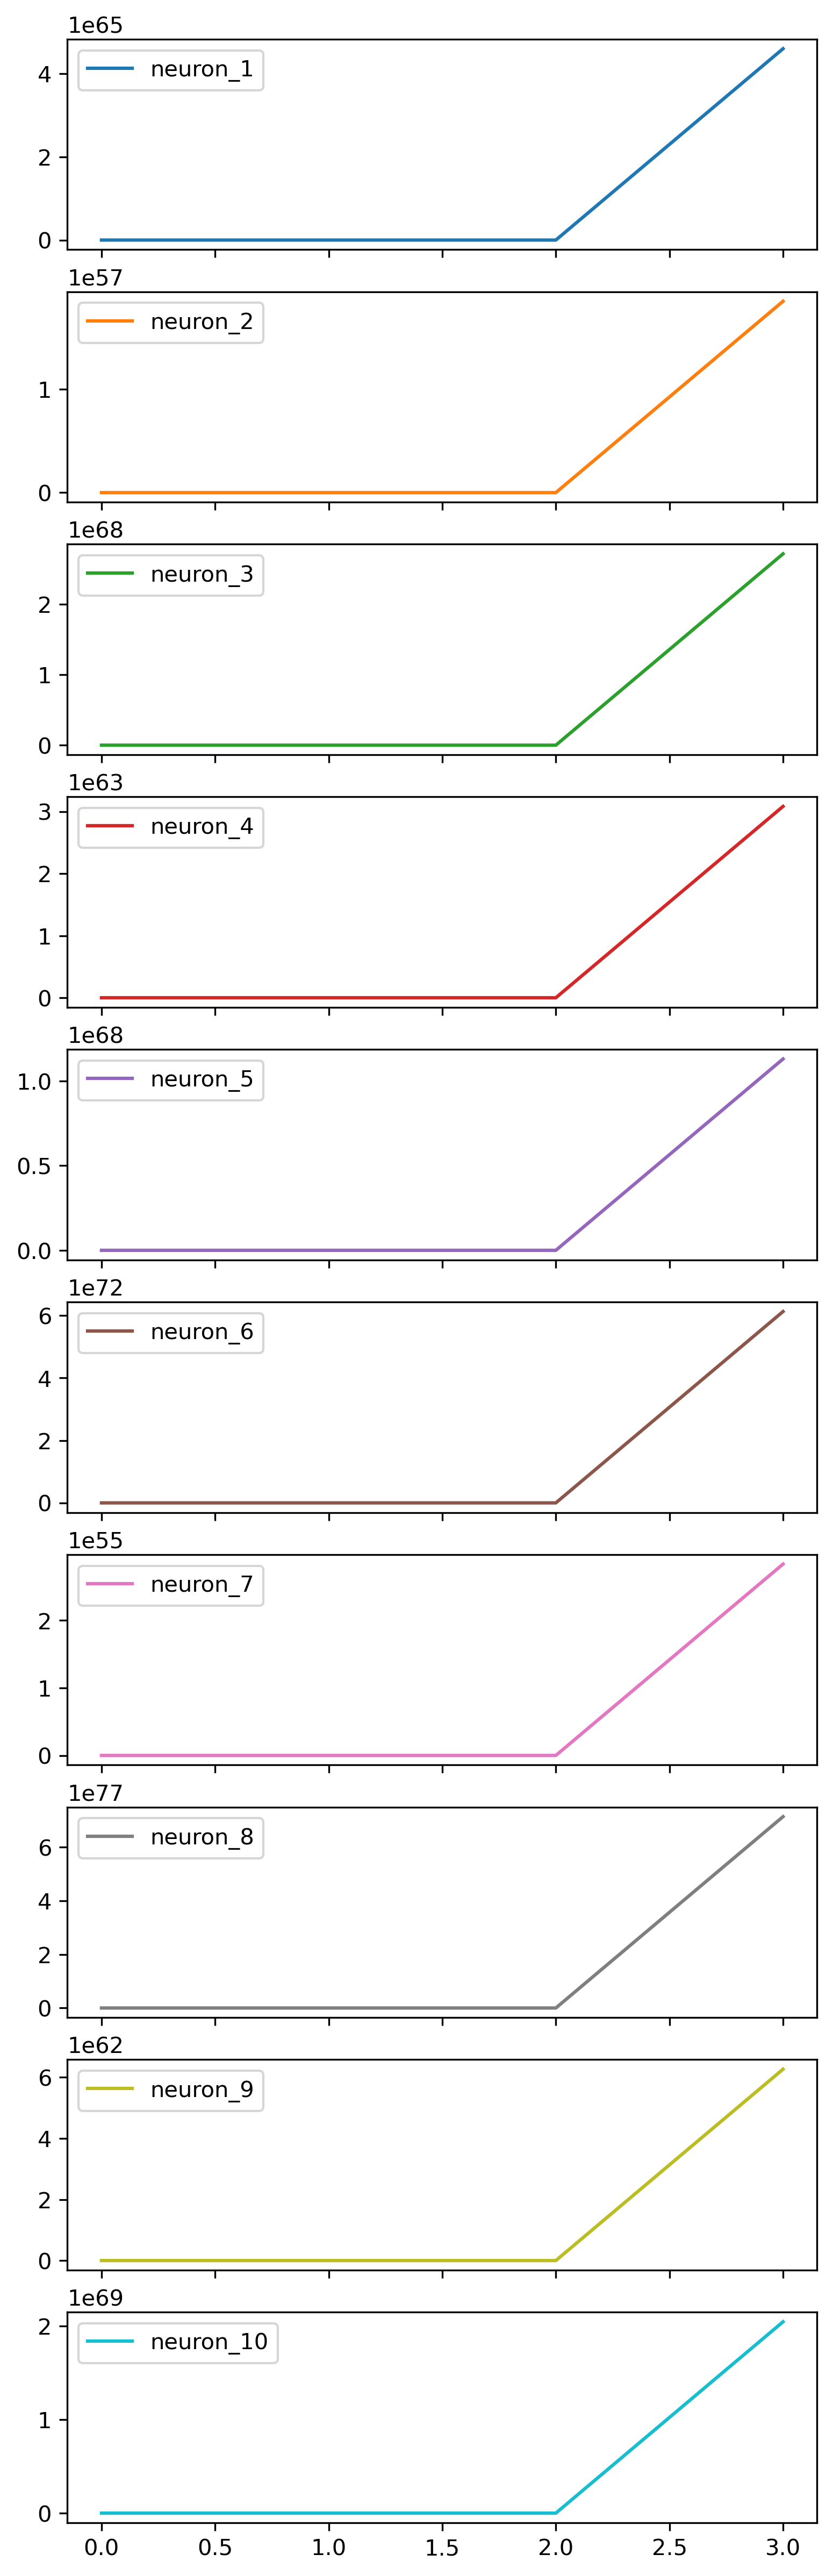

In [386]:
import pandas as pd
df = pd.DataFrame({f'neuron_{i+1}': t[i, :] for i in range(n_units)})
df.plot(subplots=True, figsize=(6, n_units*2))


#### Activations

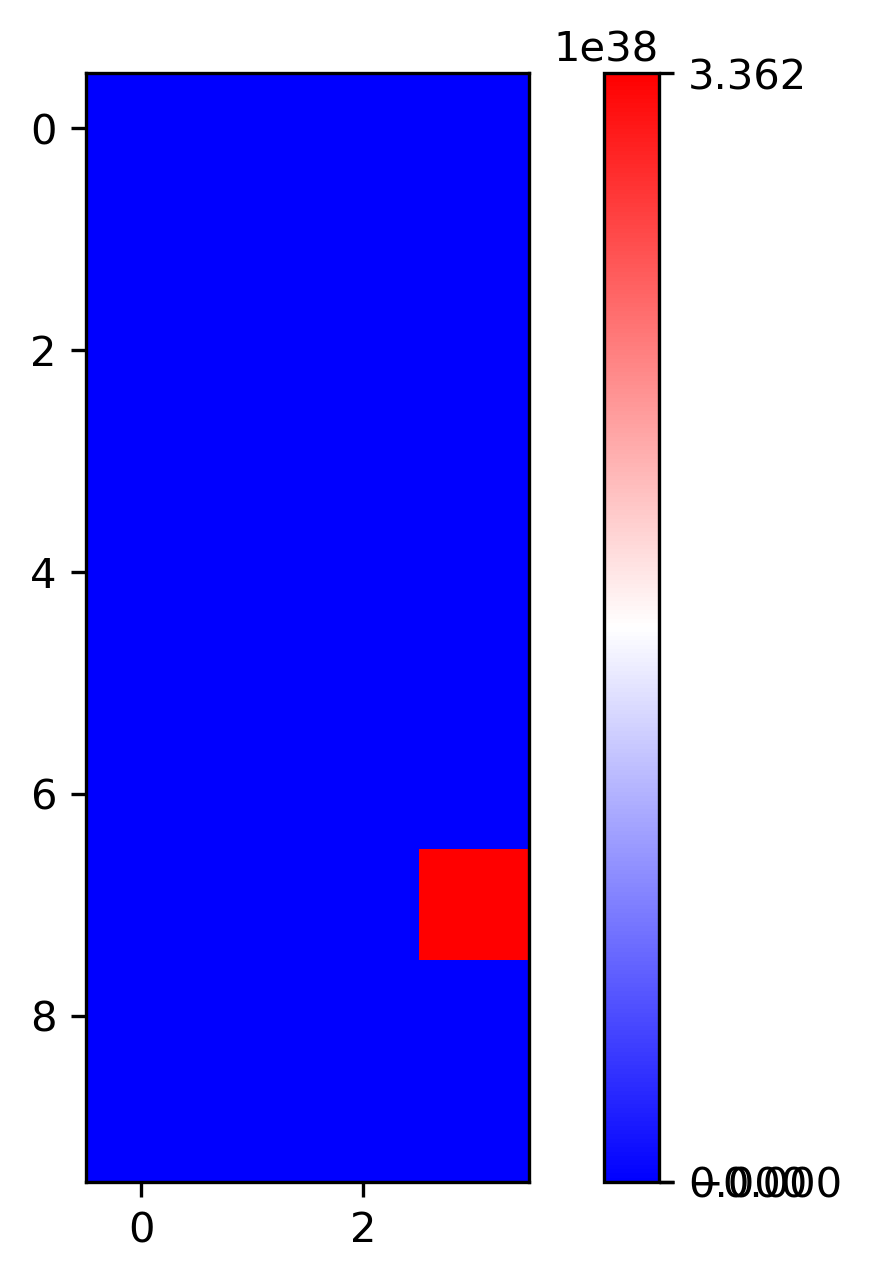

In [387]:
y = np.array(model.activations)
y = y.T
plt.imshow(y,cmap='bwr')
plt.colorbar( ticks=[np.amin(y), 0, np.amax(y)])

In [388]:
y.shape

(10, 4)

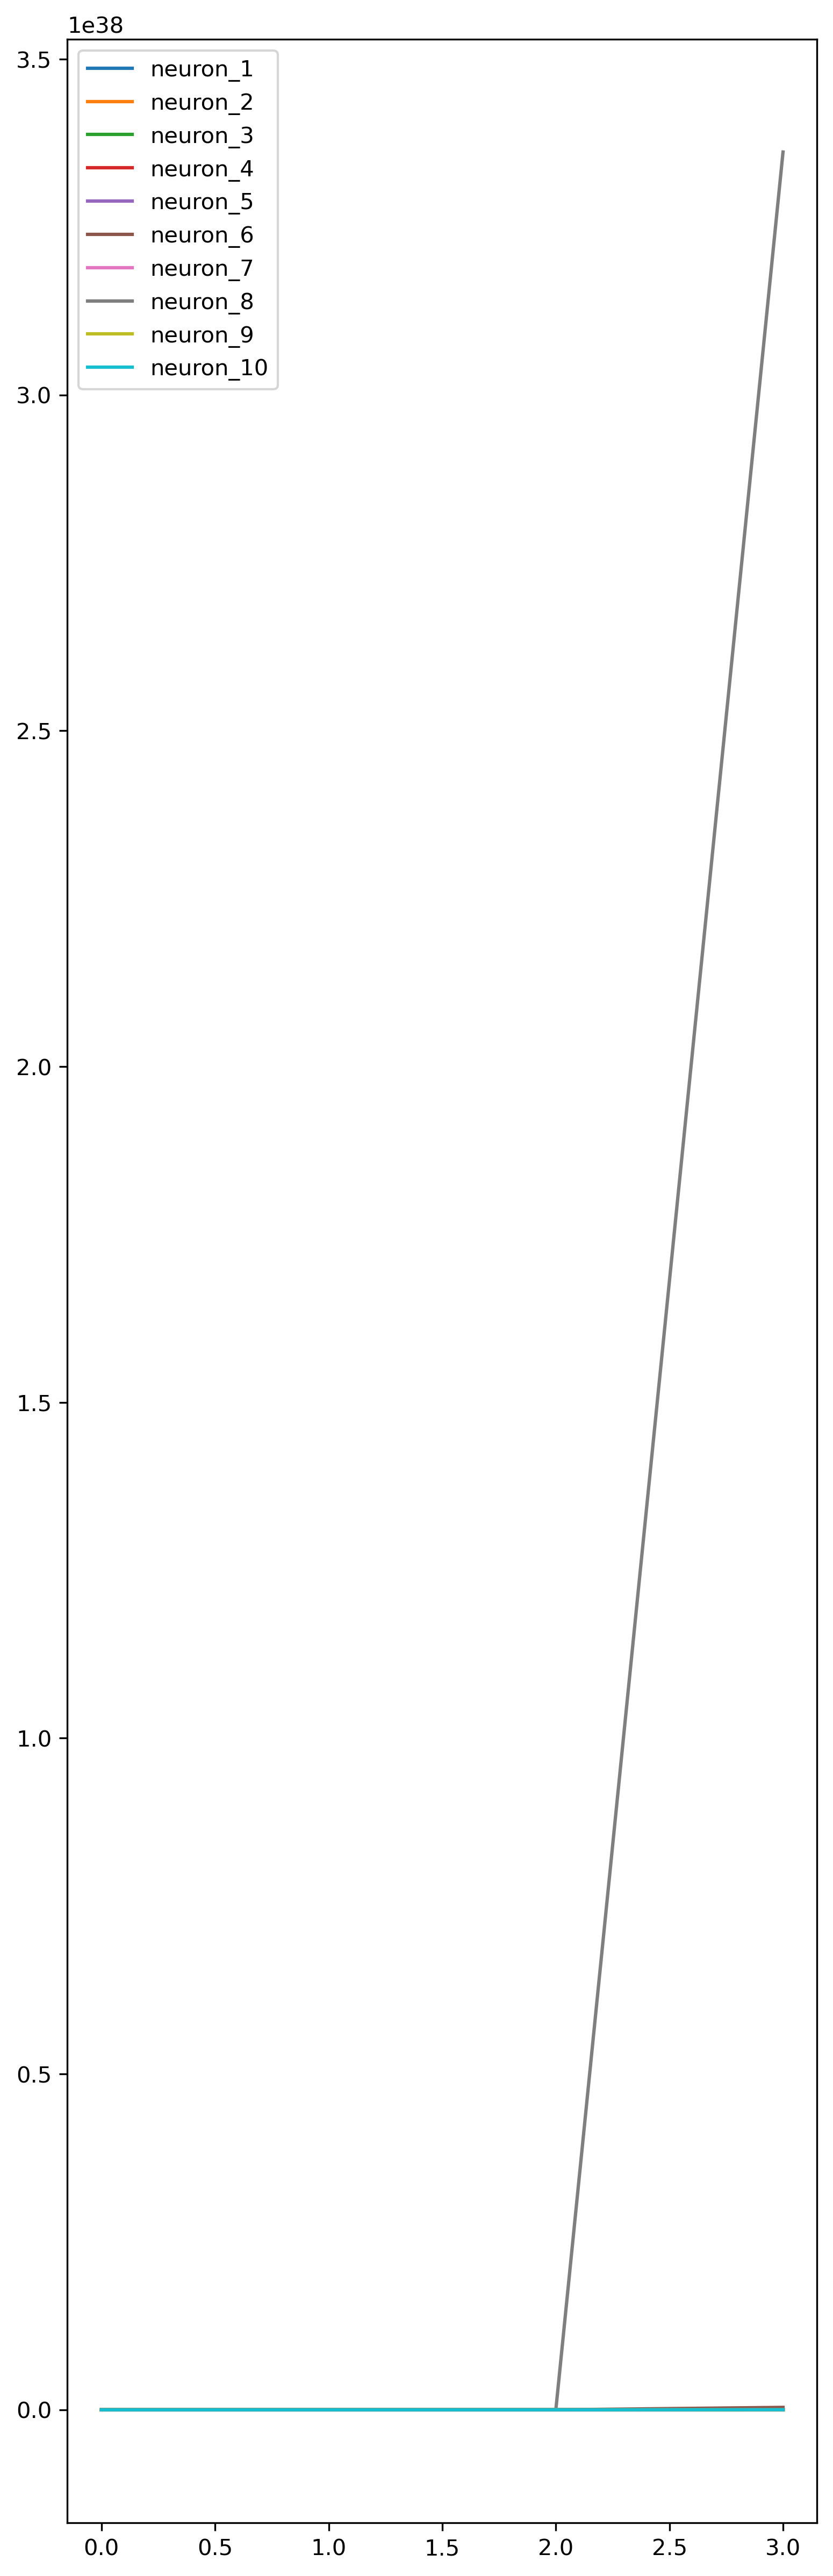

In [389]:
import pandas as pd
df = pd.DataFrame({f'neuron_{i+1}': y[i, :] for i in range(n_units)})

# plot the data with subplots and assign the returned array
axes = df.plot(figsize=(6, n_units*2))

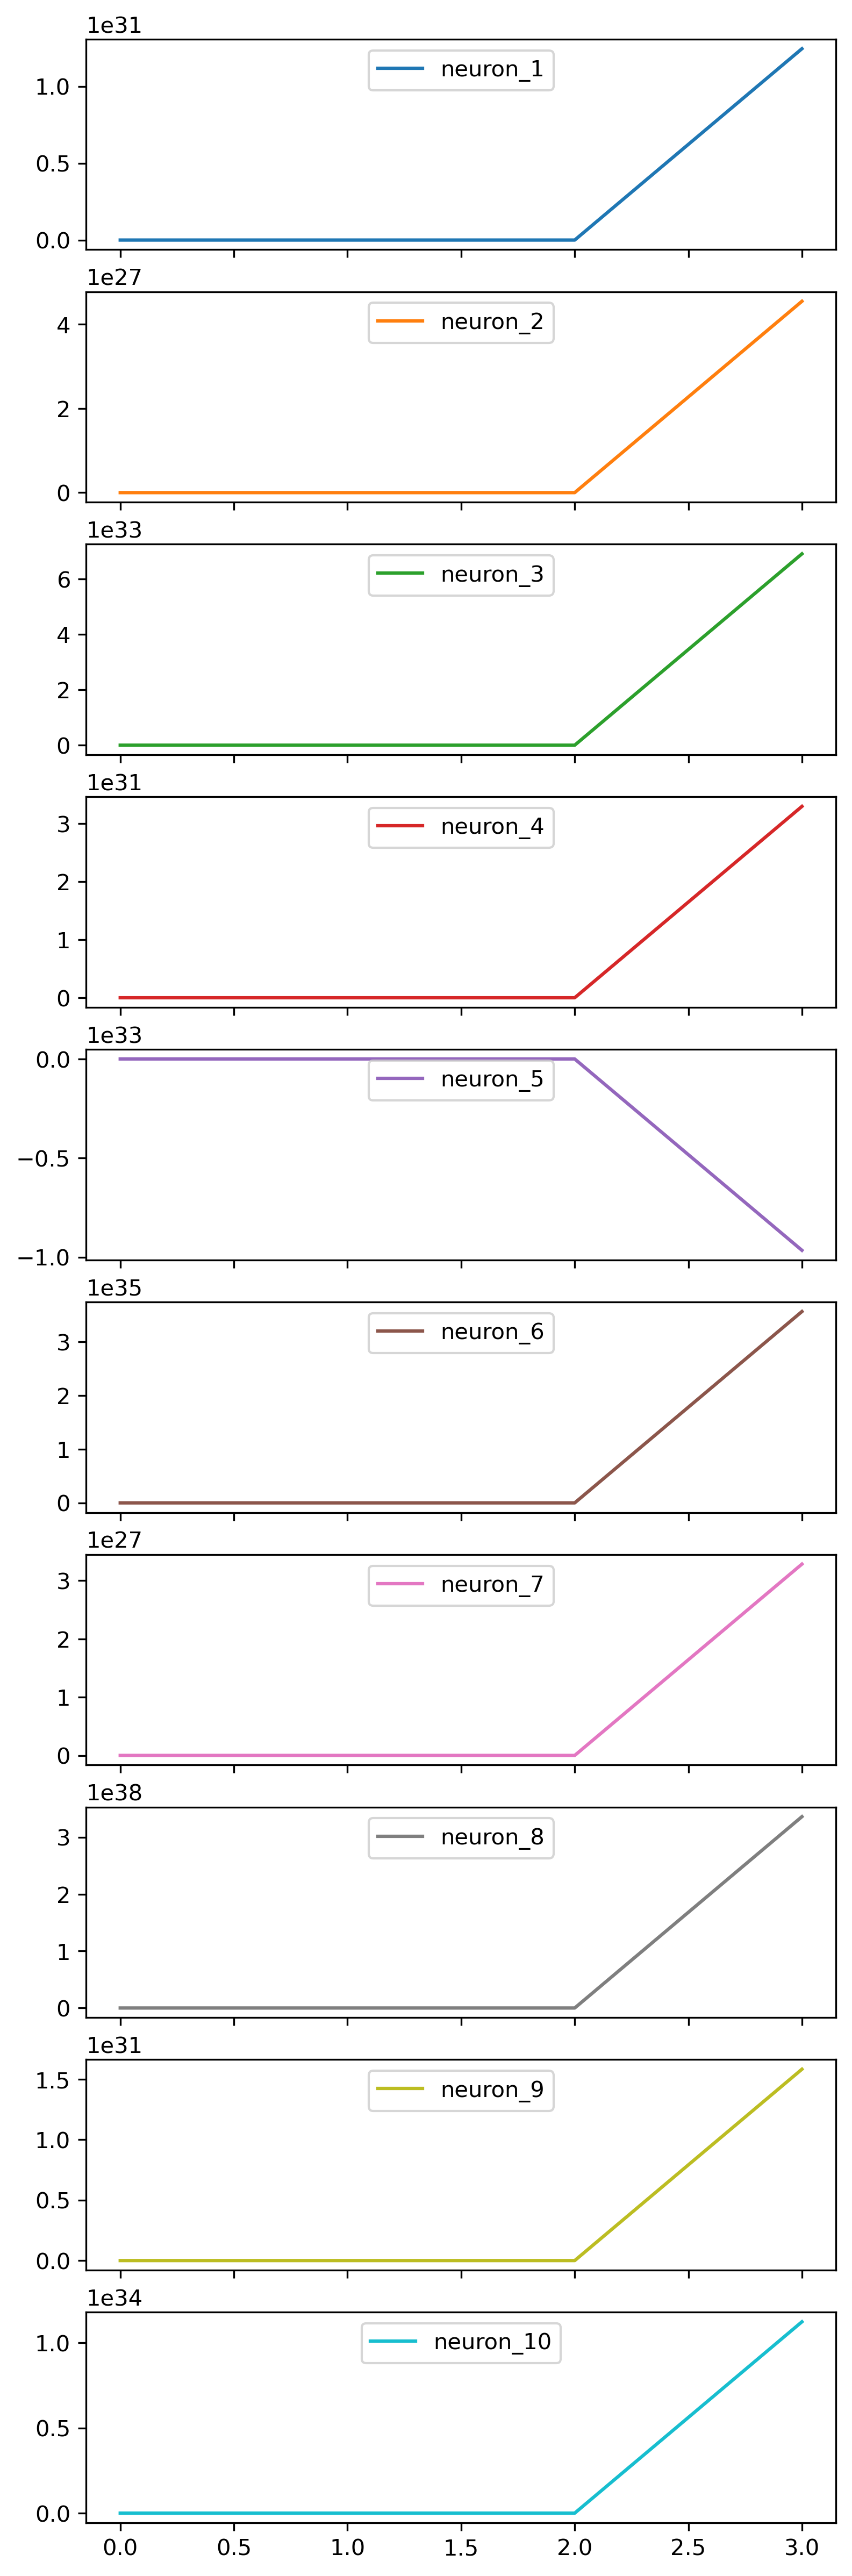

In [390]:
import pandas as pd
df = pd.DataFrame({f'neuron_{i+1}': y[i, :] for i in range(n_units)})

# plot the data with subplots and assign the returned array
axes = df.plot(subplots=True,figsize=(6, n_units*2))

# flatten the array
axes = axes.flat  # .ravel() and .flatten() also work

# extract the figure object to use figure level methods

# iterate through each axes to use axes level methods
for ax in axes:
    
    ax.legend(loc='upper center', )
    


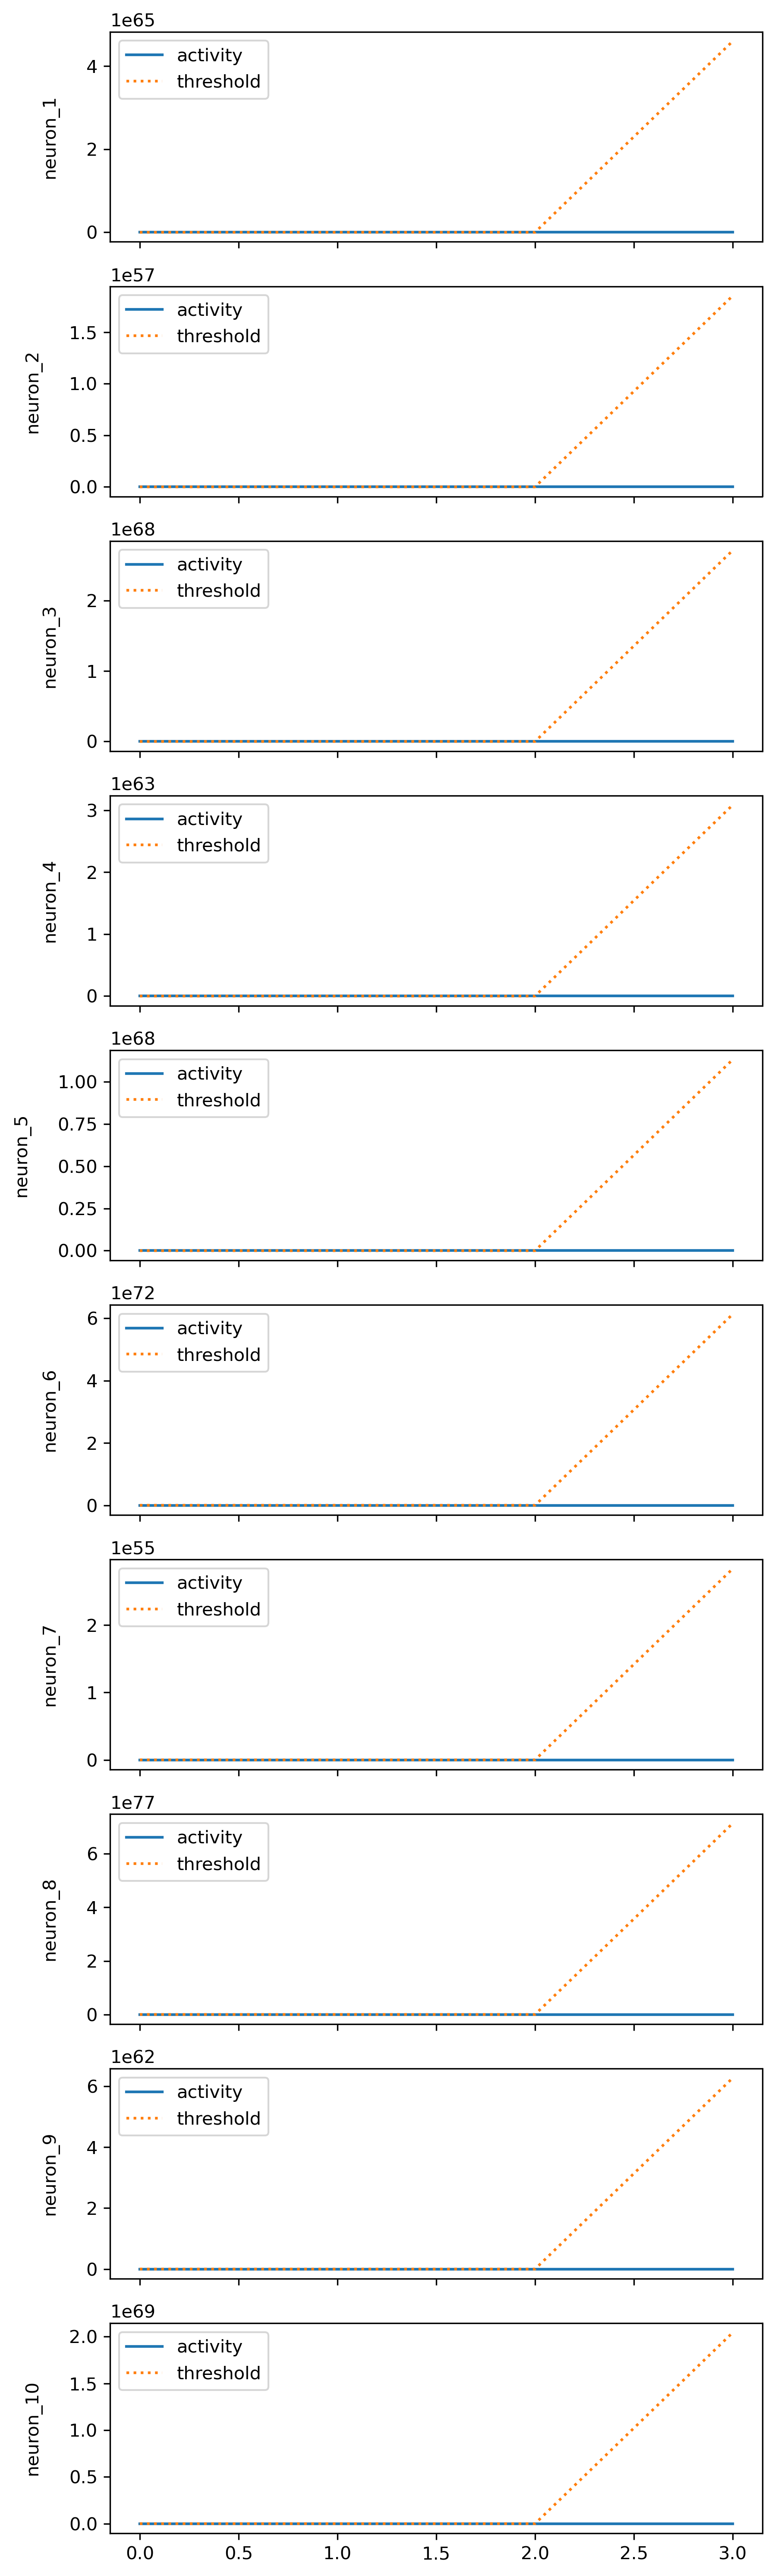

In [391]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming y and t are numpy arrays of shape (n_units, timepoints)
n_units = y.shape[0]

# Create subplots
fig, axes = plt.subplots(n_units, 1, figsize=(6, n_units*2), sharex=True)

# Loop over neurons
for i in range(n_units):
    ax = axes[i]
    
    # Plot activity
    ax.plot(y[i, :], label='activity')
    
    # Plot threshold (dotted)
    ax.plot(t[i, :], linestyle=':', label='threshold')
    
    # Set y-label as neuron label
    ax.set_ylabel(f'neuron_{i+1}', rotation=90, labelpad=20, va='center')
    
    # Optionally remove legend if labels are clear
    ax.legend()

plt.tight_layout()
plt.show()


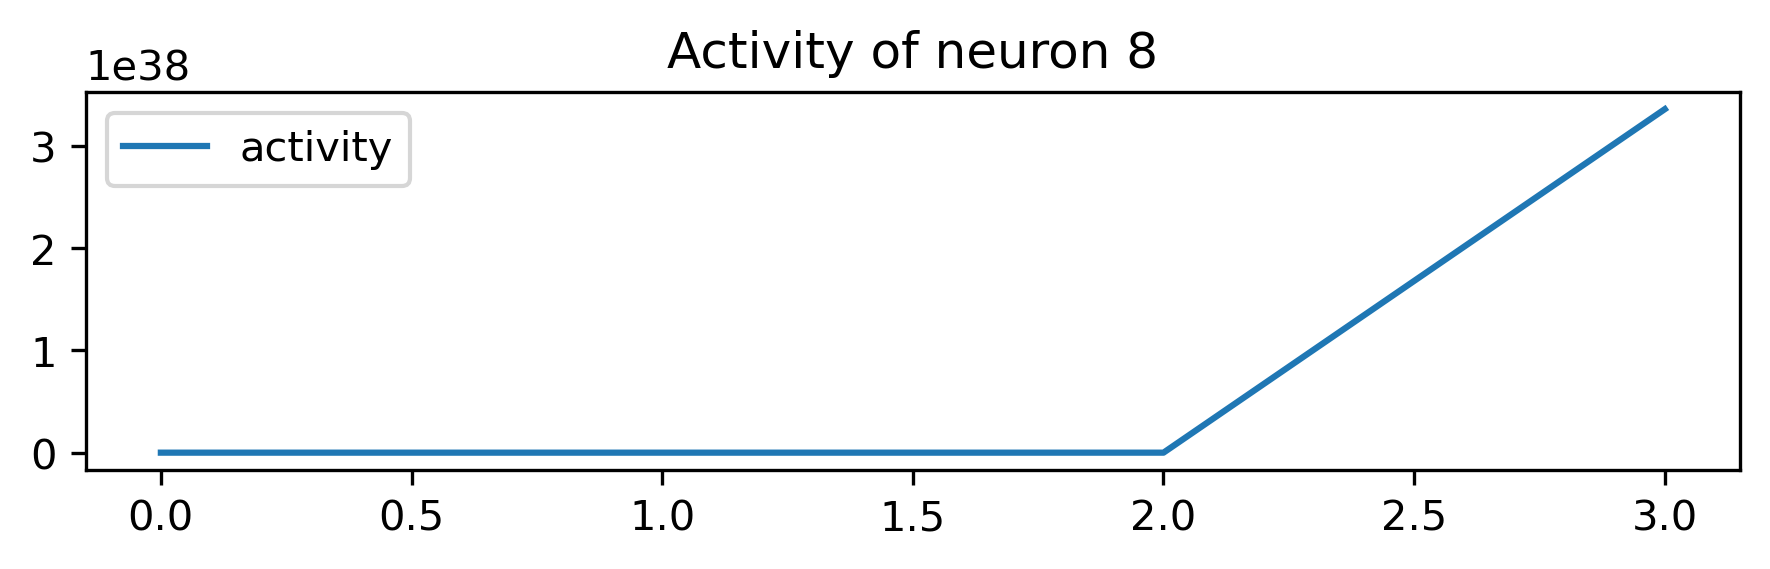

In [392]:
import matplotlib.pyplot as plt

# Select neuron index 5 (6th neuron)
i = 7

fig, ax = plt.subplots(figsize=(6, 2))

# Plot activity
ax.plot(y[i, :], label='activity')

# Plot threshold (dotted)
#ax.plot(t[i, :], linestyle=':', label='threshold')

# Set y-label as neuron label
#x.set_ylabel(f'neuron_{i}', rotation=0, labelpad=40, va='center')
# Add legend
plt.title(f"Activity of neuron {i+1}")
ax.legend()

plt.tight_layout()
plt.show()


#### Comparing Threshold & Activity 

In [393]:
import seaborn as sns

In [394]:
y.shape

(10, 4)

In [395]:
y[i,:]

array([-9.28583555e+00,  9.17687381e+03, -3.50164539e+12,  3.36176138e+38])

In [396]:
t[i,:]

array([1.32535224e+03, 7.87385446e+08, 1.33006113e+26, 7.13547335e+77])

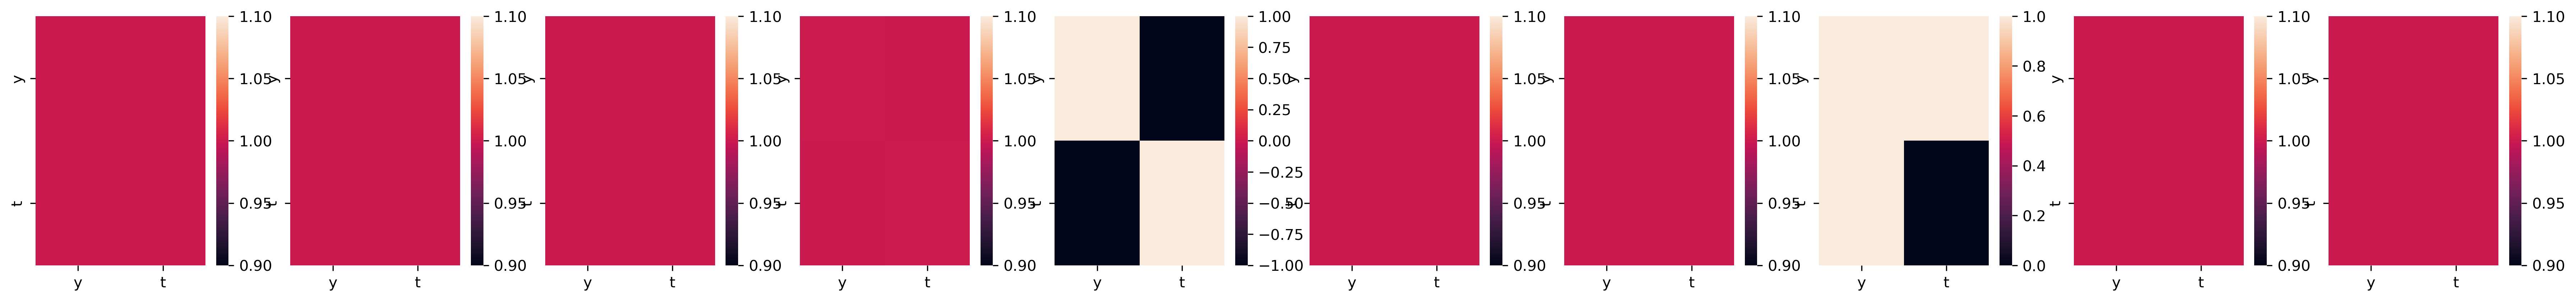

In [397]:
n_cols = n_units  # number of columns in subplot grid
n_rows = 1 # compute number of rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))

# Flatten axes array for easy indexing
axes = axes.flatten()

for i in range(n_units):
    df = pd.DataFrame({'y':y[i,:], 't':t[i,:]})
    cor = df.corr()
    sns.heatmap(cor, ax= axes[i])